Here we will learn to:
- Assess the performance of machine learning models;
- Diagnose the common problems of machine learning algorithms;
- Fine-tune machine learning models;
- Evaluate predictive models using different performance matrics.

In [2]:
import pandas as pd

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",header=None)

In [3]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:,2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
le.transform(["M","B"]) # Malign tumors as class 1 and benign tumors as class 0

array([1, 0])

In [6]:
# Dataset split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

Now we will chain the scaling, the dim-reduction and the classifier training in a pipeline as a best practice.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression())
pipe_lr.fit(X_train,y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test,y_test)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.956


The `make_pipeline` function comes in handy, taking an arbitrary number of transformers (objects that support both `fit` and `transform` methods), followed by an estimator (supports `fit` and `predict` methods).

# K-fold cross-validation to assess model performance

## The holdout method

Basically separating the training set and the test set, in order to use the former for training and the latter to estimate the generalization performance.

To select optimal values of tuning parameters, we go through a process called **model selection**.
However if we perform the model selection process using everytime the same test set, it's like if the test set becomes a part of the training set (so it's not really a good practice).

A better way of using the holdout method for model selection is to separate the data into three parts: training, test and validation dataset. Then the validation set is used for model selection, while the test set is used as the final performance estimate (after the model selection process is complete).

## K-fold cross validation
In k-fold cross validation we randomly split the training dataset into $k$ folds without replacement. This will create $k-1$ training folds, used for training and $1$ test fold, used for performance evaluation.
The procedre is repeated $k$ times so that we obtain $k$ models and performance estimates.
Typically, we use k-fold cross-validation for model tuning (finding the optimal hyperparameter values that yield a satisfying generalization performance, on the test folds). After we have found satisfactory hyperparameter values, we can retrain the model on the complete training dataset and obtain a final performance estimate using the indipendent test dataset.

Another cool property of this approach is that the estimated performances $E_i$ of each model (coming from each iteration of the k-fold) can be then used to calculate the estimated average performance $E= \frac{1}{k}\sum^k_{i=1}E_i$.

A standard vale for $k$ in k-fold cross validation is usually 10 (as empirical evidence shows). However with relatively small training sets, it can be useful to increase the number of folds (however big values of $k$ will increase the runtime of the cross-validation), while if the training set is big, we can choose a lower $k$ (for example $k=5$), and still obtain an accurate estimate.

With extremely small datasets there is also the **leave one out approach** where $k=n$, having only 1 sample for the test set.

In case of class imbalances however, a better approach is the stratified cross-validation, where the class label proportions are preserved in each fold, to ensure that each fold is representative of the class proportions in the training dataset.

In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10).split(X_train,y_train)
scores = []
for k, (train,test) in enumerate(kfold):
    pipe_lr.fit(X_train[train],y_train[train])
    score = pipe_lr.score(X_train[test],y_train[test])
    scores.append(score)
    print(f"Fold: {k+1:02d}, Class distr.: {np.bincount(y_train[train])}, Acc.: {score:.3f}")
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f"\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}")

Fold: 01, Class distr.: [256 153], Acc.: 0.935
Fold: 02, Class distr.: [256 153], Acc.: 0.935
Fold: 03, Class distr.: [256 153], Acc.: 0.957
Fold: 04, Class distr.: [256 153], Acc.: 0.957
Fold: 05, Class distr.: [256 153], Acc.: 0.935
Fold: 06, Class distr.: [257 153], Acc.: 0.956
Fold: 07, Class distr.: [257 153], Acc.: 0.978
Fold: 08, Class distr.: [257 153], Acc.: 0.933
Fold: 09, Class distr.: [257 153], Acc.: 0.956
Fold: 10, Class distr.: [257 153], Acc.: 0.956

CV accuracy: 0.950 +/- 0.014


In [9]:
# Also it could have been written less verbosely like this:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,X=X_train,y=y_train,cv=10,n_jobs=1) # using the parameter `n_jobs` we can distribute the training across CPUS (-1 means use them all)
print(f"CV accuracy scores: {scores}")

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


# Debugging algorithms with learning and validation curves

## Diagnosing bias and variance problems with learning curves

By plotting the model training and validation accuracies as functions of the taining dataset size, we can easily detect whether the model suffers from high vairance or high bias, and wheather the collection of more data could help to address this problem.

- If the training accuracy and the validation accuracy converge, but under the desired accuracy it indicates that the model underfits the training data. To address this issue usually the model parameters will be increased or maybe it's decreased the degree of regularization;
- A model with high variance is indicated by the large gap between the training and the cross-validation accuracy. To address the overfitting problem, usually more data is collected, it's often reduced the complexity of the model or it's increased the regularization parameter. Even feature selection and feature extraction could be useful.

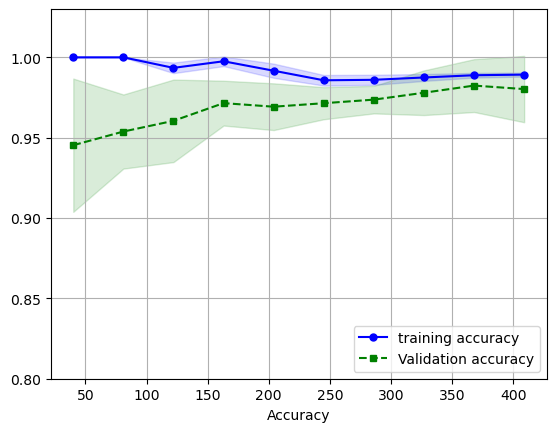

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),LogisticRegression(penalty="l2",max_iter=1000))
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,X=X_train,y=y_train,train_sizes=np.linspace(0.1,1,10),cv=10,n_jobs=-1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)
plt.plot(train_sizes,train_mean,color="blue",marker="o",markersize=5,label="training accuracy")
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color="blue")
plt.plot(train_sizes,test_mean,color="green",linestyle="--",marker="s",markersize=5,label="Validation accuracy")
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color="green")
plt.grid()
plt.xlabel("Number of training examples")
plt.xlabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim([0.8,1.03])
plt.show()

## Addressing over and underfitting with validation curves

Let's now re-plot the same curves not as a function of the training set size, but instead as a function of the regularization term.

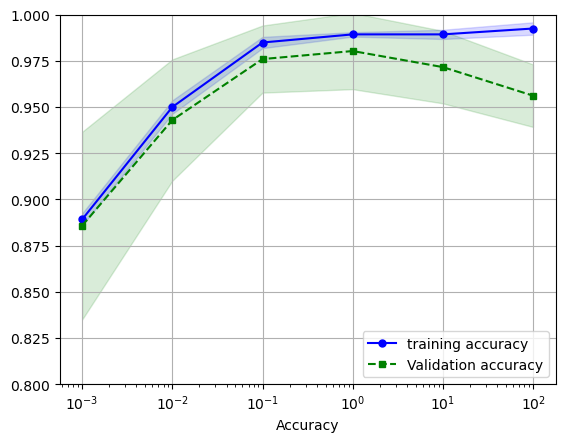

In [14]:
from sklearn.model_selection import validation_curve

param_range = [10**i for i in range(-3,3)]

train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name="logisticregression__C",
    param_range=param_range,
    cv=10,
    n_jobs=-1,
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(
    param_range,
    train_mean,
    color="blue",
    marker="o",
    markersize=5,
    label="training accuracy",
)
plt.fill_between(
    param_range,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.15,
    color="blue",
)
plt.plot(
    param_range,
    test_mean,
    color="green",
    linestyle="--",
    marker="s",
    markersize=5,
    label="Validation accuracy",
)
plt.fill_between(
    param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green"
)
plt.grid()
plt.xscale("log")
plt.xlabel("Parameter C")
plt.xlabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim([0.8, 1.0])
plt.show()

Inside the validation_curve function, we specified the parameter that we wanted to evaluate.

As we can see the bigger the C (after $C=10^0$) the less regularization is applied, and as a consequence the more overfitted will be the model, while we can clearly see that the more C is little, the more the regularization is strong, and the more the model becomes too simple to truly approximate the data.

## Fine-tuning machine learning models via grid search

The hyper-parameters of a learning algorithm are optimized separately to the parameters of the model.
Let's learn how to tune hyper-parameters via grid search.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_range = [10**i for i in range(-4,4)]
param_grid = [
    {'svc__C': param_range,"svc__kernel":['linear']},
    {'svc__C': param_range,"svc__gamma":param_range,"svc__kernel":['rbf']},
]
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring="accuracy",cv=10,refit=True,n_jobs=-1)
gs = gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


Here we initialized a GridSearchCV (CV for cross validation). For the linear SVM we've only evaluated the inverse regularization parameter C, as for the radial basis function (RBF) kernel SVM, they tuned both the C parameter and the gamma parameters.
Then we gained the accuracy of the best performing model, and the best hyper-parameters in order to create that model.

In [16]:
clf = gs.best_estimator_ # <-- we are extracting the best model
clf.fit(X_train,y_train)
print(f"Test accuracy: {clf.score(X_test,y_test):.3f}")

Test accuracy: 0.974


## Exploring hyperparameter configurations more widely with randomized search

Specifying large hyperparameter grids makes grid search very expensive in practice, here's where randomized search comes in handy.

In randomized search, we draw hyperparametr combinations from distributions (or discrete sets). Doing so, randomized search doesn't do an exhaustive search overthe hyperparameter space, but it's more cost-effective and time-effective.

In [21]:
import scipy.stats
param_range = scipy.stats.loguniform(
    0.0001, 1000.0
)  # log uniform so that it uniformly samples values proportionally across orders of magnitude rather than linearly
np.random.seed(1)
param_range.rvs(10)

array([8.30145146e-02, 1.10222804e+01, 1.00184520e-04, 1.30715777e-02,
       1.06485687e-03, 4.42965766e-04, 2.01289666e-03, 2.62376594e-02,
       5.98924832e-02, 5.91176467e-01])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
param_grid = [
    {'svc__C': param_range,"svc__kernel":['linear']},
    {'svc__C': param_range,"svc__gamma":param_range,"svc__kernel":['rbf']},
]
rs = RandomizedSearchCV(estimator=pipe_svc,param_distributions=param_grid,scoring="accuracy",refit=True,n_iter=20,cv=10,random_state=1,n_jobs=-1)
rs = rs.fit(X_train,y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9780676328502416
{'svc__C': 0.05971247755848463, 'svc__kernel': 'linear'}


## More resource-efficient hyperparameter search with successive halving

1. Draw a larg set of candidate configurations via random sampling;
2. Train the models with limited resources, for example, a small subset of the training data;
3. Discard the bottom 50 percent based on predictive performance;
4. Go back to step 2 with an increased amount of available resources.

In [24]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

hs = HalvingRandomSearchCV(pipe_svc,param_distributions=param_grid,n_candidates="exhaust",resource="n_samples",factor=1.5,random_state=1,n_jobs=-1)
hs = hs.fit(X_train,y_train)
print(hs.best_score_)
print(hs.best_params_)
clf = hs.best_estimator_
print(f"Test accuracy: {hs.score(X_test,y_test):.3f}")

0.9617647058823529
{'svc__C': 4.934834261073333, 'svc__kernel': 'linear'}
Test accuracy: 0.982


# Algorithm selection with nested cross-validation

If we want to select across different machine learning algorithms, the recommended approach is **nested cross-validation**.

In [27]:
# Using Support Vectors
param_range = [10**i for i in range(-4,4)]
param_grid = [
    {'svc__C': param_range,"svc__kernel":['linear']},
    {'svc__C': param_range,"svc__gamma":param_range,"svc__kernel":['rbf']},
]
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring="accuracy",cv=2)
scores = cross_val_score(gs,X_train,y_train,scoring="accuracy",cv=5)
print(f"SVM CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

# Using Decision Tree
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),param_grid=[{"max_depth":[1,2,3,4,5,6,7,None]}],scoring="accuracy",cv=2)
scores = cross_val_score(gs,X_train,y_train,scoring="accuracy",cv=5)
print(f"DecTree CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

SVM CV accuracy: 0.974 +/- 0.015
DecTree CV accuracy: 0.934 +/- 0.016


# Looking at different performance evaluation metrics

There are several other performance metrics that can be used to measure a model's relevance, such as **precision**, **recall**, **F1 score** and **Matthews correlation coefficient** (**MCC**).

## Reading a confusion matrix

Is simply a square matrix that reports the counts of the true positive, true negative, false positive and false negative predictions of a classifier.

In [28]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


# Optimizing the precision and recall of a classification model

error (ERR):
$$ERR=\frac{FP+FN}{FP+FN+TP+TN}$$

accuracy (ACC):
$$ACC=\frac{TP+TN}{FP+FN+TP+TN} = 1-ERR$$

true positive rate (TPR)(should be 1 in a perfect case):
$$TPR=\frac{TP}{FN+TP}$$

false positive rate (FPR)(should be 0 in a perfect case):
$$FPR=\frac{FP}{FP+TN}$$

recall (REC):
$$REC=TPR=\frac{TP}{FN+TP}$$
Quantifies how many of the relevant records (the positives) are captured as such (the true positives).
Optimizing for it helps minimizing the chance of not detecting a malignat tumor (not caring about the increasing false positives).

precision (PRE):
$$PRE=\frac{TP}{FP+TP}$$
Quantifies how many of the record predicted as relevant are actually relevant.
Optimizing for it emphasize correctness if a patient is predicted to have a malignant tumor (not caring about false negatives).

F1 score:
$$F1=2\frac{PRE\times REC}{{PRE+ REC}}$$
To balance the ups and downsides of optimizing for PRE and REC.
The fact that the harmonic mean is used it's due to the fact that this way the PRE and the REC are both scaled to the same scale, and then the extreme descrepancies are hugely penalized.

MCC:
$$MCC=\frac{TP\times TN - FP\times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$
It summerizes the confusion matrix, going from -1 (completely wrong prediction, like the opposite of the perfect prediction) to 1 (perfect prediction). 0 in this case means random guessing.

The nominator measures the net difference between correct and uncorrect guesses. The denominator serves as the normalizing factor.

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

pre_val = precision_score(y_true=y_test,y_pred=y_pred)
print(f"Precision: {pre_val:.3f}")
rec_val = recall_score(y_true=y_test,y_pred=y_pred)
print(f"Recall: {rec_val:.3f}")
f1_val = f1_score(y_true=y_test,y_pred=y_pred)
print(f"F1 score: {f1_val:.3f}")
mcc_val = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
print(f"MCC: {mcc_val:.3f}")

Precision: 0.976
Recall: 0.952
F1 score: 0.964
MCC: 0.943


## Plotting a receiver operating characteristic

Useful tools to select models for classification based on their performance with respect to the FPR and TPR, computed by shifting the decision threshold of the classifier.

The diagonal of the ROC graph can be interpreted as random guessing, and models under the diagonal are considered worse than random guessing.

A perfect classifier would have TPR at 1 and FPR at 0.

Computing the area under the curve we can characterize the performance of the classification model.

Also, similarly, we can compute precision-recall curves for different proability thresholds of a classifier.

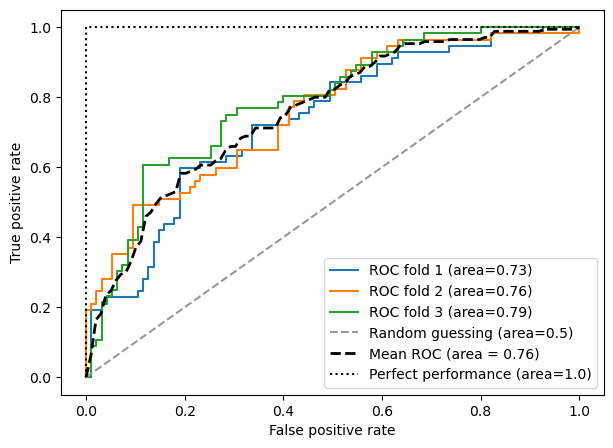

In [31]:
from sklearn.metrics import roc_curve, auc
from numpy import interp
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(penalty="l2",random_state=1,solver="lbfgs",C=100.0)
)
X_train2 = X_train[:,[4,14]]
cv = list(StratifiedKFold(n_splits=3).split(X_train,y_train))
fig = plt.figure(figsize=(7,5))
mean_tpr=0.0
mean_fpr = np.linspace(0,1,100)
all_tpr = []
for i, (train,test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],probas[:,1],pos_label=1)
    mean_tpr += interp(mean_fpr,fpr,tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,label=f"ROC fold {i+1} (area={roc_auc:.2f})")
plt.plot([0,1],[0,1],linestyle="--",color=(0.6,0.6,0.6),label="Random guessing (area=0.5)")
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr,mean_tpr)
plt.plot(mean_fpr,mean_tpr,"k--",label=f"Mean ROC (area = {mean_auc:.2f})",lw=2)
plt.plot([0,0,1],[0,1,1],linestyle=":",color="black",label="Perfect performance (area=1.0)")
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")
plt.show()

# Scoring metrics for multiclass classification

There are micro-averaging systems that using TPs, TNs and FNs of the entire system, just compute the average.
$$PRE_{micro}=\frac{TP_1+...+TP_k}{TP_1+...+TP_k+FP_1+...+FP_k}$$
Useful if we want to weight each instance or prediction equally.

While macro averaging is simply doing the average of the original metric across the entire system.
$$PRE_{macro}=\frac{PRE_1+...+PRE_k}{k}$$
Weights all the classes equally.
Usually (as a default in scikit) the single units of the nominator in the macro-averages are weighted by the number of instances of that specific class.
Useful especially if we are dealing with class imbalances.

## Dealing with class imbalance

Is when one class or multiple classes in a dataset are over-represented.

The breast cancer test dataset for example consisted of 90% of healthy patientes. This would mean that a model that achieves 90% accuracy is as good as guessing benign tumor all the time.

In [32]:
# Let's create an imbalanced training dataset

X_imb = np.vstack((X[y==0],X[y==1][:40]))
y_imb = np.hstack((y[y==0],y[y==1][:40]))
# Here we are taking all the beningn tumor exaples and we are stacking them with the first 40 malign tumor examples

y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred==y_imb)*100 # We are effectivly creating a dataset where just saying every time "benign tumor" achieve 90% of accuracy


89.92443324937027

Remember that class imbalances influence a learning algorithm during model fitting. The decision rule is likely to be biased towards the majority class.

One way to deal with this is to assign a larger penality to wrong predictions on the minority class (in scikit is as simple as setting `class_weight="balanced"`).

You could downsample the majority class or upsample the minority class, or maybe generate synthetic training examples. However there's no universally best solution that works best across different problem domains.

In [36]:
# Example of upsampling

from sklearn.utils import resample
print("Number of class 1 examples before: ",X_imb[y_imb==1].shape[0])
X_upsampled, y_upsampled = resample(X_imb[y_imb==1],y_imb[y_imb==1],replace=True,n_samples=X_imb[y_imb==0].shape[0],random_state=123)
print("Number of class 1 examples before: ",X_upsampled.shape[0])

# Then we re-create the dataset
X_bal = np.vstack((X[y==0],X_upsampled))
y_bal = np.hstack((y[y==0],y_upsampled))

y_pred = np.zeros(y_bal.shape[0])
np.mean(y_bal==y_pred)*100 # We are effectivly creating a dataset where just saying every time "benign tumor" achieve 50% of accuracy

Number of class 1 examples before:  40
Number of class 1 examples before:  357


50.0

We can of course use the `resample` method to downsample the majority class.

> Note: we could also use the **SMOTE** synthetic data generation technique (the most widely used) in order to create fake but realistic datapoints.